## Group: Jingmin Chen, Tinayu Sun

# Introductions

I'll compare a series of binary logistic models on dateaset of the Federal Reserve Bank of Boston. To achieve this, I'll perform my work roughly in following steps

1.  fetch the dataset and load them by python
2.  understand meaning of each feature
3.  perform EDA on the dataset and gain some useful information from this for further work
4.  perform necessary data preparation on the dataset. 
5.  perform variable selection on the dataset and gain several subsets
6.  train several logistic models on datasets gained previously, and judge their performance.

What's more, the detail things will be given in each individual step.

In [11]:
# load pytho libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import normalized_mutual_info_score, accuracy_score, make_scorer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

## 1. load dataset and understanding

In this step I'll fetch the dataset from internet and store them as a file. Then I'll use python to load the file

In [12]:
# load data from file
# ignore first column as index
data = pd.read_csv('https://raw.githubusercontent.com/TTZUO/DAV-6150/master/M7_Data.csv', index_col=0)

In [13]:
print(data.shape)
print(data.columns)

(2381, 13)
Index(['dir', 'hir', 'lvr', 'ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single',
       'uria', 'comdominiom', 'black', 'deny'],
      dtype='object')


We can see the dataset contains 2381 observatiuons of 1 response variable called `deny` and 12 explanatory variables. 

Here are the meaning of each variable I found on internet.

-   dir: debt payments to total income ratio

-   hir: housing expenses to income ratio

-   lvr: ratio of size of loan to assessed value of property

-   ccs: consumer credit score from 1 to 6 (a low value being a good score)

-   mcs: mortgage credit score from 1 to 4 (a low value being a good score)

-   pbcr: public bad credit record ?

-   dmi: denied mortgage insurance ?

-   self: self employed ?

-   single: is the applicant single ?

-   uria: 1989 Massachusetts unemployment rate in the applicant's industry

-   condominium: is unit a condominium ? (was called comdominiom in version -  0.2-9 and earlier versions of the package)

-   black: is the applicant black ?

-   deny: mortgage application denied ?



## EDA

In this step I'll perfrom some EDA on the dataset to explore the hidden information in it.

At first I'll take a glance at the dataset to see if there are invalid data entries.

In [15]:
# look at first 5 observations of dataset
data.head()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
1,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
2,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
3,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
4,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
5,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


In [16]:
# look at type of variables
data.dtypes

dir            float64
hir            float64
lvr            float64
ccs            float64
mcs            float64
pbcr            object
dmi             object
self            object
single          object
uria           float64
comdominiom      int64
black           object
deny            object
dtype: object

In [17]:
# look at some statistic results on continuous variables
data.describe()

,dir,hir,lvr,ccs,mcs,uria,comdominiom
count,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,0.330814,0.255346,0.737760,2.116387,1.721008,3.774496,0.288114
std,0.107235,0.096635,0.178715,1.666370,0.537169,2.026636,0.452980
min,0.000000,0.000000,0.020000,1.000000,1.000000,1.800000,0.000000
25%,0.280000,0.214000,0.652850,1.000000,1.000000,3.100000,0.000000
50%,0.330000,0.260000,0.779412,1.000000,2.000000,3.200000,0.000000
75%,0.370000,0.298800,0.868421,2.000000,2.000000,3.900000,1.000000
max,3.000000,3.000000,1.950000,6.000000,4.000000,10.600000,1.000000


In [18]:
for f in ['pbcr', 'dmi', 'self', 'single', 'comdominiom', 'black', 'deny']:
    print(data[f].value_counts())
    print()


no     2205
yes     175
Name: pbcr, dtype: int64

no     2333
yes      48
Name: dmi, dtype: int64

no     2103
yes     277
Name: self, dtype: int64

no     1444
yes     937
Name: single, dtype: int64

0    1695
1     686
Name: comdominiom, dtype: int64

no     2042
yes     339
Name: black, dtype: int64

no     2096
yes     285
Name: deny, dtype: int64



In [21]:
# check if the data contain null value
data.isnull().sum()

dir            0
hir            0
lvr            0
ccs            0
mcs            0
pbcr           1
dmi            0
self           1
single         0
uria           0
comdominiom    0
black          0
deny           0
dtype: int64

### conclusion
As we can see that there are 4 numerical variables and 9 categorial variables (including respoinse variable). Each categorial variables only contains 2 valid value (no and yes or 0 and 1). 

What's more, variable `pbcr` and `self` contains one invalid data entries. These data entrise must be handled before they encounter with logistic models. 

I found there are invalid values in `ccs` and `mcs` (only one value is float but others are all integer). So `ccs` and `mcs` should be categorial variables rather then continuous variables. These outliers will be filled to nearest integer.

In [22]:
# remove outliers in `ccs` and `mcs`
data.mcs[(data.mcs > 1) & (data.mcs < 2)] = round(data.mcs[(data.mcs > 1) & (data.mcs < 2)])
data.ccs[(data.ccs > 2) & (data.ccs < 3)] = round(data.ccs[(data.ccs > 2) & (data.ccs < 3)])

/Users/TTzuo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/TTzuo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


And then, I'll perform some visualization on the dataset to see distributions of each variable. At first, I'll visualize categroial variables.

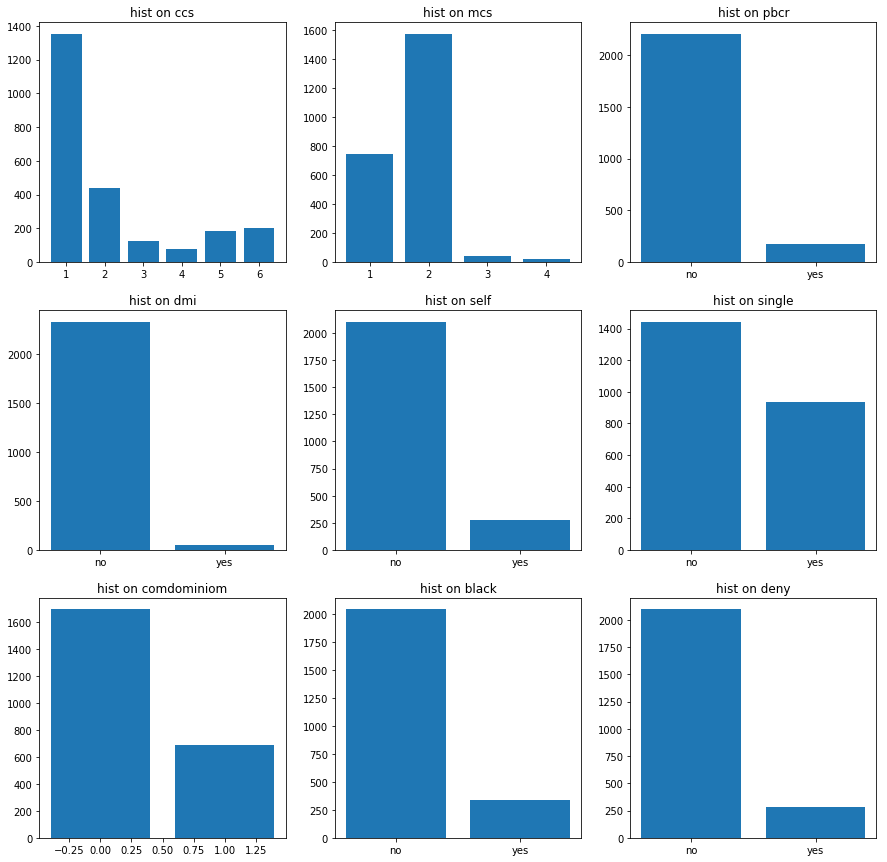

In [23]:
# set figure size
fig = plt.figure(figsize=(15, 15))

i = 1
# plot the distribution for categroial variables
for f in ['ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single', 'comdominiom', 'black', 'deny']:
    plt.subplot(3, 3, i)    

    vc = data[f].value_counts()
    plt.bar(vc.index, vc.values)
    plt.title('hist on {}'.format(f))

    i += 1
plt.show()
    

### conclusion
We can find that the distribution of each categorial variable is skewed. Observations of `no` (for `comdominiom` is 0) is more then `yes` (for `comdomniom` is 1). 
This will provide indication on data preparation.

What's more, the response variable is also skewed.

And then I'll explore distributions of continuous variables.

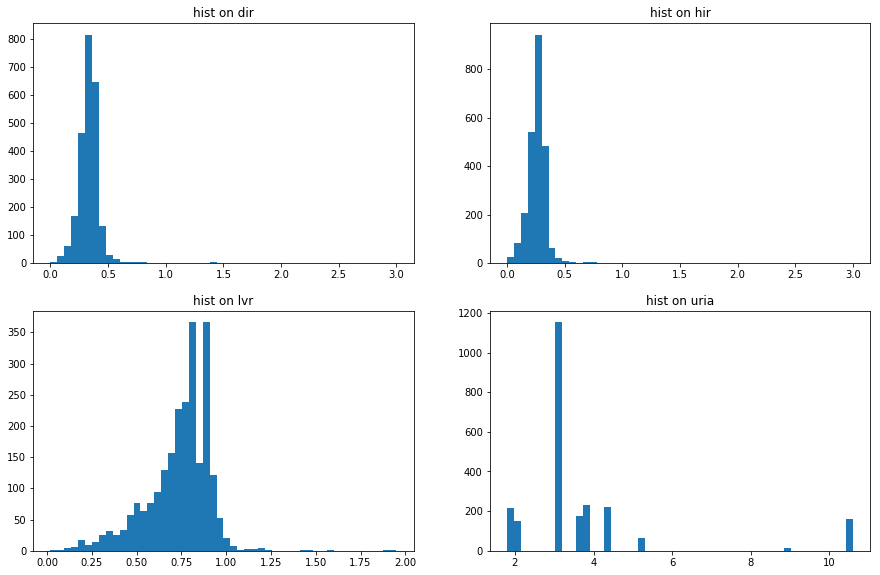

In [32]:
#set figure size
fig = plt.figure(figsize=(15, 15))
i = 1
# plot distribution for continuous variables
for f in ['dir', 'hir', 'lvr', 'uria']:
    plt.subplot(3, 2, i)
    plt.hist(data[f], bins=50)
    plt.title('hist on {}'.format(f))

    i += 1
plt.show()

### conclusion

We can see that `dir` and `hir` seems to obey a normal distribution, but `lvr` is skewed and `uria` seems not obey a normal distribution.

What's more, I'll explore relationships between continuous variables.

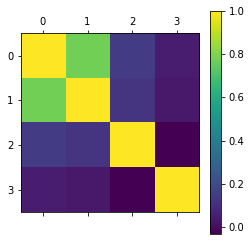

In [33]:
features = ['dir', 'hir', 'lvr', 'uria']
# find the correlation for continuous variables
corr_mat = data[features].corr()
plt.matshow(corr_mat)
plt.colorbar()

plt.show()

## conclusion

From the correlation matrix we can see that `dir` and `hir` have a high relationship then others. They are not isolated on some aspects

Here I'll explore relationships between categorial variables. I'll use NMI score (this score is used to judge dependency between two variables and suitable for categorial data, higher value indicates dependency) to represent the strength of relationship.

NMI on ccs and mcs: 0.02582051423762276
NMI on ccs and pbcr: 0.06665646389440599
NMI on ccs and dmi: 0.0045775221030329985
NMI on ccs and self: 0.0038681901203775383
NMI on ccs and single: 0.0035896236557910544
NMI on ccs and comdominiom: 0.0098883602299372
NMI on ccs and black: 0.03152974191633219

NMI on mcs and pbcr: 0.0049644472387428504
NMI on mcs and dmi: 0.00755936187888833
NMI on mcs and self: 0.016570528421977128
NMI on mcs and single: 0.032605142132423465
NMI on mcs and comdominiom: 0.013521682962874627
NMI on mcs and black: 0.023137948937526076

NMI on pbcr and dmi: 0.01528420679728626
NMI on pbcr and self: 0.013053257880906024
NMI on pbcr and single: 0.0009278784663615586
NMI on pbcr and comdominiom: 0.001481446483596183
NMI on pbcr and black: 0.031305877184663114

NMI on dmi and self: 0.0006771505339648917
NMI on dmi and single: 0.0006928220470437765
NMI on dmi and comdominiom: 6.228389882433005e-05
NMI on dmi and black: 0.014385423753706246

NMI on self and single: 0.0013

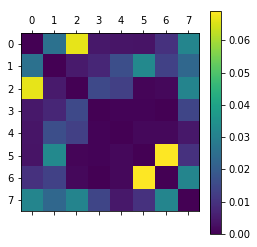

In [34]:
# NMI between categorial variables

features = ['ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single', 'comdominiom', 'black']
# copy data
tmp_data = data.copy()

nmi_mat = np.zeros((8, 8))

for i in range(len(features)):
    for j in range(i + 1, len(features)):
        
        f1 = features[i]
        f2 = features[j]

        tmp_data[f1][data[f1] == 'no'] = 0
        tmp_data[f1][data[f1] == 'yes'] = 1

        tmp_data[f2][data[f2] == 'no'] = 0
        tmp_data[f2][data[f2] == 'yes'] = 1

        nmi = normalized_mutual_info_score(tmp_data[f1], tmp_data[f2])

        nmi_mat[i, j] = nmi
        nmi_mat[j, i] = nmi

        print('NMI on {} and {}: {}'.format(f1, f2, nmi))
    print()

plt.matshow(nmi_mat)
plt.colorbar()
plt.show()


In [51]:
# NMI between categorial variables and response variable

features = ['ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single', 'comdominiom', 'black']

tmp_data = data.copy()

tmp_data['deny'][tmp_data.deny == 'no'] = 0
tmp_data['deny'][tmp_data.deny == 'yes'] = 1

for i in range(len(features)):
        
    f = features[i]

    if f not in ['ccs', 'mcs']:
        tmp_data[f][data[f] == 'no'] = 0
        tmp_data[f][data[f] == 'yes'] = 1

    nmi = normalized_mutual_info_score(tmp_data[f], tmp_data['deny'])

    print('NMI on {} and deny: {}'.format(f, nmi))
    print()


NMI on ccs and deny: 0.04365598452625967

NMI on mcs and deny: 0.012018231081151224

NMI on pbcr and deny: 0.0827747179992331

NMI on dmi and deny: 0.18391183335684919

NMI on self and deny: 0.0034012593589535446

NMI on single and deny: 0.005775637982416272

NMI on comdominiom and deny: 0.0016344101514051254

NMI on black and deny: 0.04383459631128729



### conclusion

From the result we can see that most categorial variables are independent, but `ccs` and `pbcr` and `single` and `comdominiom` seem to dependent (NMI score greater then 0.5)

What's more, `dmi` and `deny` seem to have more relationship because their NMI score is higher then others (0.18).

## Data preparation

In this step I'll perform some data preparation which including impute Empty value and categorial variable format.

Empty value imputing will based on distributions gained above.

I'll use one-hot encoding to format categortial variables beside `ccs` and `mcs` because they have more than 2 categories. `ccs` and `mcs` is categorial variables but their observations can be compared by their value, so I'll not convert them.

`deny` will not be convert to one-hot encoding because it is response variable. I'll change no to 0 and yes to 1 in `deny`.


Empty values are disappering in `pbcr` and `self` as described above. There are more no in these two variables then yes, and there are only 1 empty value in each variable, so use just no to replace them is ok.

In [37]:
# Impute empty variables

data.pbcr.fillna('no', inplace=True)
data.self.fillna('no', inplace=True)

In [38]:
print(data.isnull().sum())

dir            0
hir            0
lvr            0
ccs            0
mcs            0
pbcr           0
dmi            0
self           0
single         0
uria           0
comdominiom    0
black          0
deny           0
dtype: int64


All empty data cleaned

In [39]:
# get dummy variables
feature_data = pd.get_dummies(data[['dir', 'hir', 'lvr', 'ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single',
       'uria', 'comdominiom', 'black']])

label_data = data['deny']
label_data[label_data == 'no'] = 0
label_data[label_data == 'yes'] = 1
label_data = label_data.astype(np.int)

proc_data = pd.concat([feature_data, label_data], axis=1)

After that, we can see the distribution of response variable on each explanatory variables.

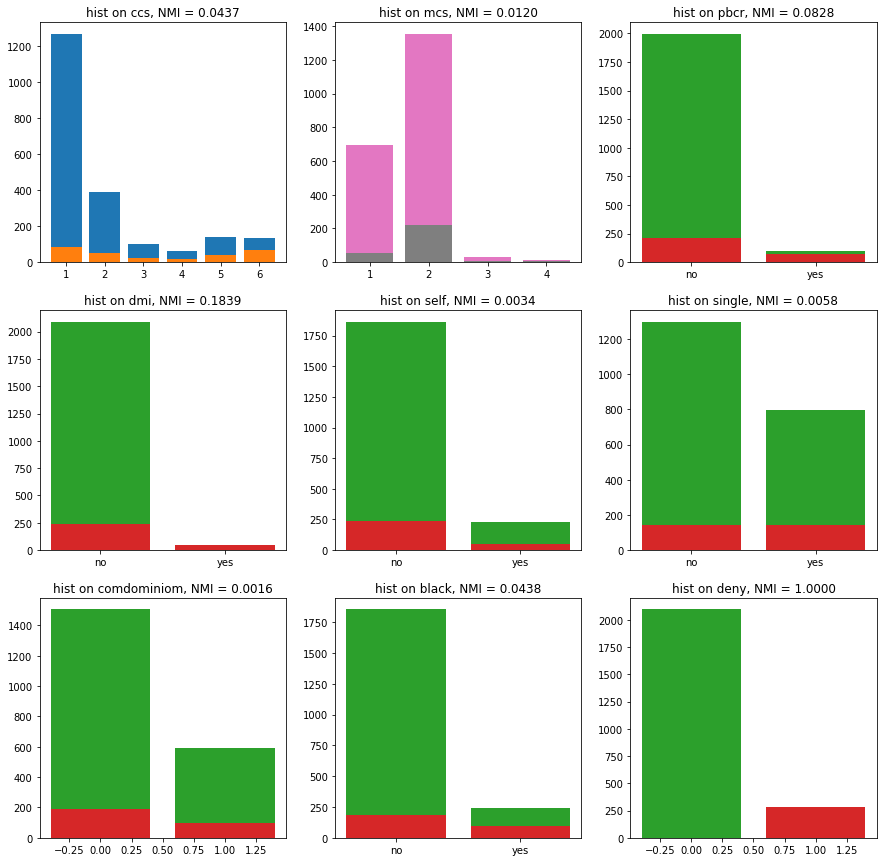

In [53]:
# set figure size
fig = plt.figure(figsize=(15, 15))

tmp_data = data.copy()

i = 1
# plot the distribution for category variables
for f in ['ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single', 'comdominiom', 'black', 'deny']:
    plt.subplot(3, 3, i)    

    values = np.unique(tmp_data[f])
    
    heights = np.zeros((len(values), 2))

    for j, v in enumerate(values):
        val_cnt = tmp_data['deny'][tmp_data[f] == v].value_counts()
        if 0 in val_cnt.index:
            heights[j, 0] = val_cnt[0]
        if 1 in val_cnt.index:
            heights[j, 1] = val_cnt[1]
    
    for j in range(len(values)):
        plt.bar(x=values, height=heights[:, 0])
        plt.bar(x=values, height=heights[:, 1])

    nmi = normalized_mutual_info_score(tmp_data[f], tmp_data['deny'])
    plt.title('hist on {}, NMI = {:.4f}'.format(f, nmi))

    i += 1
plt.show()

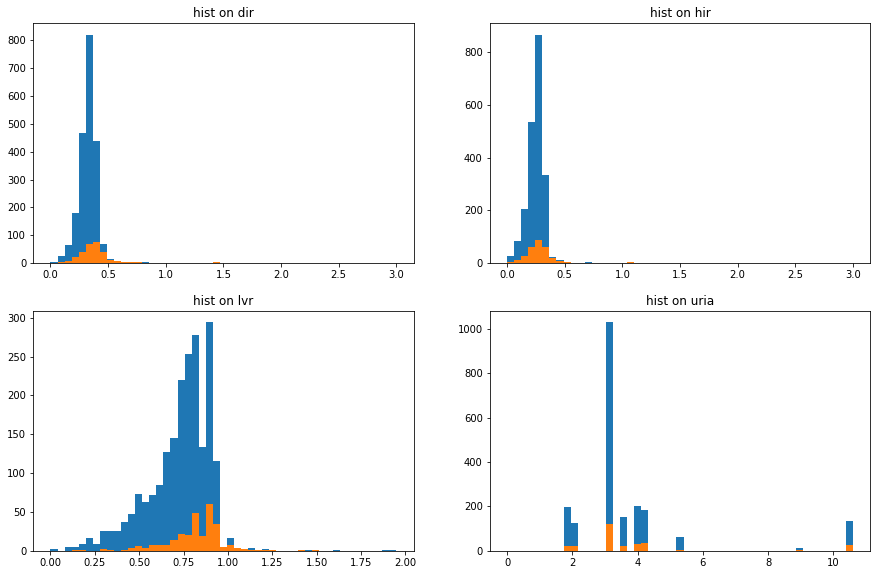

In [61]:
fig = plt.figure(figsize=(15, 15))
bin_num = 50

tmp_data = data.copy()
# plot distribution for continuous variables
i = 1
for f in ['dir', 'hir', 'lvr', 'uria']:
    plt.subplot(3, 2, i)

    bins = np.linspace(0, tmp_data[f].max(), bin_num)

    for v in [0, 1]:

        plt.hist(tmp_data[f][tmp_data.deny == v], bins=bins)


    # plt.hist(data[f], bins=50)
    plt.title('hist on {}'.format(f))

    i += 1
plt.show()

We can see that all categorial variables are converted to one-hot encoding except `deny`. This dataset will be used for further process. The dataset is ready to feed in model.

What's more, I illustrated distribution of response variable on each explanatory variables. I think it is hard to distinguish which variable contributes more to response variable from these figures, so the following steps will rely on NMI score.

## Variable selection and Train-Test split

In this step, dataset will be copied 3 times for 3 logistic models. Each copied dataset will be split into train set and test set with split ratio 0.7. Each dataset will have different explanatory variables. Explanatory variables will be choosen by backward selection. Before this, importance of each variable will be calculated by decision tree.





In [55]:
# copy 3 dataset

data1 = proc_data.copy()
data2 = proc_data.copy()
data3 = proc_data.copy()

In [56]:
# calculate variable importance

dt = DecisionTreeClassifier()
dt.fit(feature_data.values, label_data.values)

feature_importance = dt.feature_importances_
print(feature_importance)

[0.21097158 0.12312677 0.20505053 0.07489234 0.03347488 0.06528021
 0.03453581 0.00142353 0.06037804 0.         0.1240201  0.01146133
 0.00777756 0.007549   0.01896419 0.01456171 0.0065324 ]


I'll perform different variable selection strategy on each dataset to generate 3 different dataset to train 3 different logistic models. 
Here are description of 3 datasets:
-   full datset with no variable removed
-   perform variable selection with importance higher then 0.01
-   manual variable selection based on EDA

In [61]:
# the first dataset

X_data_1 = data1.iloc[:, :-1]
y_data_1 = data1.iloc[:, -1]
# split the data into training and testing subsets.
# We'll set aside 70% of the data for training purposes;
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_data_1.values, y_data_1.values, train_size=0.7)

Variable selection on the second dataset will based on variable importance calculated above.

In [85]:
# the second dataset


remaining_features = list(feature_data.columns[feature_importance >= 0.01])
# split the data into training and testing subsets.
# We'll set aside 70% of the data for training purposes;
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data2[remaining_features].values, data2['deny'], train_size=0.7)
    

The explanatory variables of the third dataset is choosen manually based on result of EDA. We known that all categorial variables are skewed in this dataset, but some are critical skewed like `dim`, `black`, `pbcr` and `mcs`. In these variables, some categories are fare more then others. I think this unbalance may fool the model and categories with less number will not contribute more to prediction. So I'll remove these features from dataset. However, `mcs` is different from others because this variables contains level data which can be compared, not just categories, so I'll keep this variable.

I also find that some categorial variables are high related such as `ccs` and `pbcr` and `single` and `comdominiom`. These two pair of variables will only keep one. Since `pbcr` has already been removed, `ccs` will be kept. For `single` and `comdominiom`, `single` will be kept because `single` has a higher NMI with `deny` then `comdominiom`. 

So the remaining categorial variables are `ccs`, `mcs`, `self` and `single`. I'll remove all subvariables detrived from those removed variables since all categorial variables are converted to one-hot encoding.

For continuous variables, I known that `dir` and `hir` are strong related through the correlate matrix and their distributions are similar. So I'll keep one randomly.
The remaining continuous variables are `dir`, `lvr` and `uria`.


In [63]:
# the third dataset

X_data_3 = data3[['dir', 'lvr', 'ccs', 'mcs', 'uria', 'self_no', 'self_yes', 'single_no',
       'single_yes']]
y_data_3 = data3['deny']
# split the data into training and testing subsets.
# We'll set aside 70% of the data for training purposes;
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_data_3, y_data_3, train_size=0.7)

## Training logistic models

I'll train 3 different logistic models on 3 different dataset described above.

In [90]:
# K is equal to 5 and this means it gets 5 accuracies
k = 5

In [95]:
# first model
# Define a logistic regression model
model1 = LogisticRegression()
model1.fit(X_train_1, y_train_1)
# use cross_val_score to get the score
score = cross_val_score(model1, X_train_1, y_train_1, cv=k, scoring=make_scorer(accuracy_score)).mean()
print(score)

pred_y = model1.predict(X_test_1)
# get accuracy_score
acc = accuracy_score(pred_y, y_test_1)
print(acc)

0.9003614392835949
0.9048951048951049


In [96]:
# second model
# Define a logistic regression model
model2 = LogisticRegression()
model2.fit(X_train_2, y_train_2)
# use cross_val_score to get the score
score = cross_val_score(model2, X_train_2, y_train_2, cv=k, scoring=make_scorer(accuracy_score)).mean()
print(score)

pred_y = model2.predict(X_test_2)
# get accuracy_score
acc = accuracy_score(pred_y, y_test_2)
print(acc)

0.8997694830679464
0.9062937062937063


In [99]:
# third model
# Define a logistic regression model
model3 = LogisticRegression()
model3.fit(X_train_3, y_train_3)
# use cross_val_score to get the score
score = cross_val_score(model3, X_train_3, y_train_3, cv=k, scoring=make_scorer(accuracy_score)).mean()
print(score)

pred_y = model3.predict(X_test_3)
# get accuracy_score
acc = accuracy_score(pred_y, y_test_3)
print(acc)

0.8841542140943339
0.8783216783216783


## Conclusion

I construct each model on training set and use cross validate to test their performance. And then test them on unseen data. I found that model 1 which remaining all explanatory variables got highest accuracy score on training set but model 2 get highest accuracy score on test dataset. So I think the best model is model 2 though it has lower accuracy score on training set than model 1. Model 2 is simplier than model 1 and has higher generalization on unseen data, which means that this model can do better on prediction on unseen data and it is useful in application. 